## 26/03/2021 
 

Fulll model proposed in the paper 

In this notebook the full model from the paper is implemented. This involves making an update of the distribution of the normal sound for each batch. We run the EM algorithm to update the distribution. The EM is run for a number of iterations so that it converges. 




Same as before, we would want to  set up the model

In [4]:
import torch 
import json 
import numpy as np 

# SubsetRandomSampler enables us to sample from the dataset. 
from sklearn.model_selection import train_test_split 

# dataloaders are good for not loading everything into memory and do it lazily
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from torch.autograd import Variable 

from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [5]:
DATA_PATH = "./data/synthetic/train_data.json"
VARIOUS_PATH = "./data/synthetic/various_data.json"

TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH_E = "./models/model_paper_full_E.pth"
SAVED_MODEL_PATH_D = "./models/model_paper_full_D.pth"
SAVED_MODEL_PATH_G = "./models/model_paper_full_G.pth"

In [120]:
def load_dataset(data_path):
    '''this loads the json file into dictionaries... still putting everything on memory '''
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    ''' Loads everything to the GPU '''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    '''Creates a dataloader which automatically puts things to the device '''
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        '''when used as an iterator this puts the batch onto the GPU before yielding it out'''
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    

# this is the training dataset containing only the normal sound samples
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)


# This contains various sounds, in this instance it is sound augmented by random dropping noises
X_v,y_v=load_dataset(VARIOUS_PATH)
X_v = torch.from_numpy(X_v).float()
y_v = torch.from_numpy(y_v).float()
dataset_v = TensorDataset(X_v,y_v)

# Test set contains normal sound samples, void sound samples at 1 snr and 0.5 snr.
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

# Creating dataloaders from the datasets. 
train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)
train_v_dl = DataLoader(dataset_v, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')

# decorating the dataloaders so that they load the data to the GPU automatically
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
train_v_dl = DeviceDataLoader(train_v_dl, device)

In [121]:
print(dataset_v[0])


(tensor([[[ -4.5665,  -4.2654,  -2.0106,  ...,  -7.3952, -30.4272, -14.4969],
         [ -6.3087,  -1.6650,  -4.4025,  ...,  -4.7651,  -8.7342, -11.2030],
         [-10.0447,   0.7506, -15.0677,  ...,  -2.3365,  -4.7488,  -8.5136],
         ...,
         [  7.1638,  14.0634,   6.9419,  ...,   1.2602,   6.0377,   3.9916],
         [  7.6228,  14.4680,   8.4123,  ...,   4.6743,   6.2258,   5.5481],
         [  7.7135,  16.0502,  15.1875,  ...,  10.8009,   9.3816,   9.7769]]]), tensor(0.))


In [142]:
latent_size = 9
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Encoder(nn.Module):
    '''Encoder is a convolutional'''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)

    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out1 = self.relu(self.linear(out))
        out2 = self.relu(self.linear(out))
        
        return out1, out2
    
def reparameterise(mu, log_var, training_mode):
    if training_mode:
        std = torch.exp(0.5*log_var)
        eps = Variable(std.data.new(std.size()).normal_())
        sample = mu + (eps*std)
        return sample 
    else:
        return mu 
    
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_size,4096)
        self.relu = nn.LeakyReLU(0.2)

        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
        
    def forward(self, xb):
        out = self.fc(xb)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out

E_module = Encoder()
G_module = Decoder()
D_module = Decoder()

E_module.to(device)
G_module.to(device)
D_module.to(device)
#E_module.load_state_dict(torch.load(SAVED_MODEL_PATH_E))
#G_module.load_state_dict(torch.load(SAVED_MODEL_PATH_G))
#D_module.load_state_dict(torch.load(SAVED_MODEL_PATH_D))

Decoder(
  (fc): Linear(in_features=9, out_features=4096, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [143]:
from torchsummary import summary 
print(summary(E_module, input_size = (1,128,16)))
print(summary(G_module, input_size = (1,9)))
print(summary(D_module, input_size = (1,9)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                    [-1, 9]          36,873
         LeakyReLU-9                    [-1, 9]               0
           Linear-10                    [-1, 9]          36,873
        LeakyReLU-11                    [-1, 9]               0
Total params: 166,418
Trainable params: 166,418
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 9])
torch.Size([150, 9])


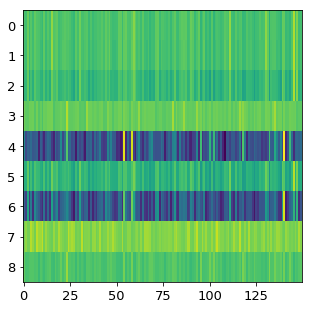

In [156]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out, _ = E_module(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out.detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img.T, aspect = 'auto')


In [145]:



def loss_function(images, reconstructed, mu,logvar):
    mse = nn.MSELoss()
    mse_loss = mse(images,reconstructed)
    
    KLD = -0.5*torch.sum(1+logvar - mu.pow(2) - logvar.exp())/(BATCH_SIZE*128*16)
    return KLD+mse_loss

# The np loss is defined as the TPR minus the FPR. We cannot compute this exactly in an efficient manner so we can instead 
def NP_loss(images_u, reconstructed_u, images_a, reconstructed_a, phi):
    mse1 = nn.MSELoss(reduction ="none")
    m_a = torch.mean(mse1(images_a, reconstructed_a), dim =(1,2,3))
    m_u = torch.mean(mse1(images_u, reconstructed_u), dim =(1,2,3))
    #print(m_a,m_u, phi)
    tpr = torch.mean(torch.sigmoid(m_a-phi))
    fpr = torch.mean(torch.sigmoid(m_u-phi))
    return fpr - tpr 
    

In [146]:
e_opt= torch.optim.Adam(E_module.parameters(), lr = 0.0002)
d_opt= torch.optim.Adam(D_module.parameters(), lr = 0.0002)
g_opt= torch.optim.Adam(G_module.parameters(), lr = 0.0002)





## 26/03/2021 

## The important part 

We will need to keep track of the latent variables created by normal sound under the current encoder network. We will run em on this at each training step. We first put here the various EM functions needed. 

These have been explored in the previous notebook, includes the functions to compute the likelihood of the datapoints under the a guassian by component, 


The likelihoods under each component is computed by get_likelihoods 

then the posterior function calculates the posterior probability of all the data given the parameters. 




In [147]:
def initialize(data, K, var = 1):
    
    indx = torch.from_numpy(np.random.choice(data.size(0),K, replace = False)).long()
    mu = data[indx]
    d = data.size(1)
    
    # initialises the variance to the provided variance. default is 1 
    var = to_device(torch.Tensor(K,d).fill_(var), device)
    
    # initialises the prior. This is defaulted to a uniform.
    pi = to_device(torch.empty(K).fill_(1./K), device)
    
    return mu, var, pi

log_norm_constant = -0.5 * np.log(2 * np.pi)

    
    
def log_gaussian(x, mean=0, logvar=0.):
    """
    Returns the component-wise density of x under the gaussian parameterised
    by `mean` and `logvar`
    :param x: (*) torch.Tensor
    :param mean: float or torch.FloatTensor with dimensions (*)
    :param logvar: float or torch.FloatTensor with dimensions (*)
    :param normalize: include normalisation constant?
    :return: (*) log density
    """
    if type(logvar) == 'float':
        logvar = to_device(x.new(1).fill_(logvar))

    a = (x - mean) ** 2
    log_p = -0.5 * (logvar + a / logvar.exp())
    log_p = log_p + log_norm_constant

    return log_p  

def get_likelihoods(X, mu, logvar, log=True):
    """
    Compute the likelihood of each data point under each gaussians.
    :param X: design matrix (examples, features)
    :param mu: the component means (K, features)
    :param logvar: the component log-variances (K, features)
    :param log: return value in log domain?
        Note: exponentiating can be unstable in high dimensions.
    :return likelihoods: (K, examples)
    """
    
    # get feature-wise log-likelihoods (K, examples, features)
    log_likelihoods = log_gaussian(
        X[None, :, :], # (1, examples, features)
        mu[:, None, :], # (K, 1, features)
        logvar[:, None, :] # (K, 1, features)
    )
    
    # sum over the feature dimension
    log_likelihoods = log_likelihoods.sum(-1)
    
    if not log:
        log_likelihoods.exp_()

    return log_likelihoods


def get_posteriors(log_likelihoods, log_pi):
    """
    Calculate the the posterior probabities log p(z|x), assuming a uniform prior over
    components (for this step only).
    :param likelihoods: the relative likelihood p(x|z), of each data point under each mode (K, examples)
    :param log_pi: log prior (K)
    :return: the log posterior p(z|x) (K, examples)
    """
    posteriors = log_likelihoods # + log_pi[:, None]
    posteriors = posteriors - logsumexp(posteriors, dim=0, keepdim=True)
    return posteriors


    """
    :param X: design matrix (examples, features)
    :param log_posteriors: the log posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    





def get_density(point, mu, logvar, pi):

    # get the design matrix
    
    # compute the densities under each mixture
    P = get_likelihoods(point, mu, logvar, log=False)
    print(P.size())
    # sum the densities to get mixture density
    Z = torch.sum(P, dim=0).data.numpy()
    
    return X, Y, Z

    
    
def logsumexp(x, dim, keepdim=False):
    """
    :param x:
    :param dim:
    :param keepdim:
    :return:
    """
    max, _ = torch.max(x, dim=dim, keepdim=True)
    out = max + (x - max).exp().sum(dim=dim, keepdim=keepdim).log()
    return out
   
    
def get_parameters(X, log_posteriors, eps=1e-6, min_var=1e-6):
    """
    :param X: design matrix (examples, features)
    :param log_posteriors: the log posterior probabilities p(z|x) (K, examples)
    :returns mu, var, pi: (K, features) , (K, features) , (K)
    """
    
    posteriors = log_posteriors.exp()

    # compute `N_k` the proxy "number of points" assigned to each distribution.
    K = posteriors.size(0)
    N_k = torch.sum(posteriors, dim=1) # (K)
    N_k = N_k.view(K, 1, 1)

    # get the means by taking the weighted combination of points
    # (K, 1, examples) @ (1, examples, features) -> (K, 1, features)
    mu = posteriors[:, None] @ X[None,]
    mu = mu / (N_k + eps)

    # compute the diagonal covar. matrix, by taking a weighted combination of
    # the each point's square distance from the mean
    A = X.unsqueeze(0) - mu
    var = posteriors[:, None] @ (A ** 2) # (K, 1, features)
    var = var / (N_k + eps)
    logvar = torch.clamp(var, min=min_var).log()

    # recompute the mixing probabilities
    m = X.size(1) # nb. of training examples
    pi = N_k / N_k.sum()

    return mu.squeeze(1), logvar.squeeze(1), pi.squeeze()



def solve_em(data, k, d, nb_iters):
    
    mu, var, pi = initialize(data, k, var=1)
    logvar = var.log()

    prev_cost = float('inf')
    thresh = 1e-5
    for i in range(nb_iters):
        # get the likelihoods p(x|z) under the parameters
        log_likelihoods = get_likelihoods(data, mu, logvar)

        # compute the "responsibilities" p(z|x)
        log_posteriors = get_posteriors(log_likelihoods, pi.log())

        # compute the cost and check for convergence
        cost = log_likelihoods.mean()
        diff = prev_cost - cost
        if torch.abs(diff).item() < thresh:
            break
        prev_cost = cost

        # re-compute parameters
        mu, logvar, pi = get_parameters(data, log_posteriors)
        
    return mu, logvar, pi 



def rej_sample(mu, logvar, mu_normal, logvar_normal):
    out = []
    factor = 100000000
    for (m, lv) in zip(mu, logvar):
        accepted = False 
        while not accepted:
            point = reparameterise(m.unsqueeze(dim = 0), lv.unsqueeze(dim = 0), True)
            like = torch.sum(get_likelihoods(point, mu_normal, logvar_normal, False), dim=0)*factor
            if like >1: 
                factor = factor//like
            if np.random.random() > like:
                accepted = True 
            else:
                print("!!!!!!!!!!!!!!!")
                print(like)
        out.append(point)
    return torch.stack(out)

        

## 26/03/2021 

A solve EM function was written to solve for the correct parameters using the EM algorithm. a set threshold on the per step difference in cost was set so that the em algorithm knows when to terminate. 

This function basically first initialises the parameters (this can potentially be the previous parameters so that it converges faster?), then for each iteration it would get the likelihoods of the data under each gausssian component. 

the posteriors are then calculated. 

here the cost is found 

the parameters can then be re-calculated and the loop can go around again. 

Now we can use this in the training of the np lemma based autoencoder model. 



In [148]:
loss_list = []
EPOCHS = 400
mse = nn.MSELoss(reduction = "none")

for epoch in range(EPOCHS):
    for (images, _),(images_v, _v) in zip(train_dl,train_v_dl):
        
        
        mu, logvar = E_module(images_v)
        normal_images = images.clone()
        mu_normal, logvar_normal = E_module(normal_images)
        
        mu_normal, logvar_normal, pi_normal = solve_em(mu_normal, 3, 9,10)
        
        #print("mu {}, var {}, pi {}".format(mu_normal.size(), logvar_normal.size(), pi_normal.size()))
        #print([(m.unsqueeze(dim = 0 ).size(),lv.size()) for m, lv in zip(mu, logvar)])
        z = rej_sample(mu,logvar, mu_normal, logvar_normal)
 
        #z = reparameterise(mu, logvar, True)
        
        
        reconstructed_a = G_module(z)
        temp = reconstructed_a.clone()

        loss = loss_function(images_v, reconstructed_a, mu, logvar)
        
        e_opt.zero_grad()
        g_opt.zero_grad()
        loss.backward()
        e_opt.step()
        g_opt.step()
    
    
        # Now do the second training step 
        reconstructed_a = temp.detach()
        
        latents,  var= E_module(images)
        recon_normal = D_module(latents)

        latents_anomalous, _= E_module(reconstructed_a)
        recon_anomalous = D_module(latents_anomalous)

        
        phi = min(torch.mean(mse(reconstructed_a.clone(), recon_anomalous.clone()), dim =(1,2,3)))
        
        loss_np = NP_loss(images, recon_normal, reconstructed_a, recon_anomalous, phi)+ loss_function(images, recon_normal,latents,var)*0.05
        
        e_opt.zero_grad()
        d_opt.zero_grad()
        loss_np.backward()
        e_opt.step()
        d_opt.step()
           
        
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}, loss_np{:.4f}'.format(epoch+1, EPOCHS, loss.item(), loss_np.item()))

        


epoch [1/400], loss:128.3628, loss_np6.2898
epoch [2/400], loss:110.0251, loss_np5.7946
epoch [3/400], loss:99.7754, loss_np5.8160
epoch [4/400], loss:90.3447, loss_np4.9090
epoch [5/400], loss:81.9972, loss_np4.7549
epoch [6/400], loss:88.1773, loss_np4.2949
epoch [7/400], loss:76.3157, loss_np4.3066
epoch [8/400], loss:70.1322, loss_np3.5999
epoch [9/400], loss:66.4697, loss_np3.9594
epoch [10/400], loss:63.6099, loss_np3.4107
epoch [11/400], loss:62.2952, loss_np3.4439
epoch [12/400], loss:60.7005, loss_np3.4016
epoch [13/400], loss:59.9730, loss_np3.0955
epoch [14/400], loss:60.8061, loss_np3.5669
epoch [15/400], loss:60.1577, loss_np4.1160
epoch [16/400], loss:57.5611, loss_np3.4964
epoch [17/400], loss:56.3093, loss_np3.9880
epoch [18/400], loss:55.8607, loss_np3.2378
epoch [19/400], loss:53.6283, loss_np3.6242
epoch [20/400], loss:55.1271, loss_np2.8937
epoch [21/400], loss:52.5968, loss_np3.8069
epoch [22/400], loss:52.5070, loss_np3.2665
epoch [23/400], loss:51.2201, loss_np3.

!!!!!!!!!!!!!!!
tensor([1.8747], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([617.9820], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([34.7424], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.4466], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3835], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.7029], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2422], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([26.3609], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1879], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.4634], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.0911], device='cuda:0', grad_fn=<MulBackward0>)
epoch [43/400], loss:48.3543, loss_np3.1984
!!!!!!!!!!!!!!!
tensor([0.5942], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.5411], device='cuda:0', grad_fn=<MulBa

epoch [49/400], loss:47.0257, loss_np3.0454
!!!!!!!!!!!!!!!
tensor([1.5597], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([420.0733], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6762], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([378.4657], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.5130], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.5024], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.7414], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([28.8044], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([98.2479], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.0928], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0844], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([66.2837], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([5.5740], device='cuda:0', grad_fn=<Mu

!!!!!!!!!!!!!!!
tensor([30.4904], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7682], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.9405], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.0814], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2258], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([26.4083], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.6946], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4671], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3934], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.7063], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.0887], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([9.2025], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1518], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2788], dev

!!!!!!!!!!!!!!!
tensor([0.6627], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([72.6585], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4514], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6228.7642], device='cuda:0', grad_fn=<MulBackward0>)
epoch [59/400], loss:48.0576, loss_np2.6692
!!!!!!!!!!!!!!!
tensor([12766.4531], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3241], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7643], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([33.9976], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([217.2901], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.3776], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6656], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1976], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.3441], device='cuda:0', grad_fn

!!!!!!!!!!!!!!!
tensor([11.0159], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.3801], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([32.7140], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([236.7531], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2195], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3190], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1448], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2002], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2471], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.0050], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1689], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.9121], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4715.3965], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([23.4019

tensor([8.6022], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6458.0737], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1090], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2103], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3938], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([11.3230], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.6438], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.6570], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2238], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.7427], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([12.3891], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7550], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6046.3975], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0086], device='cuda:

!!!!!!!!!!!!!!!
tensor([1331.1034], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.8800], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([16.8483], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4701], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([154.4899], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7863], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.2349], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.4413], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([158.5653], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5721], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.4473], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([11.8127], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1892], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.735

!!!!!!!!!!!!!!!
tensor([343.2833], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([34.9429], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.8415], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.0603], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([392.9083], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4313], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.0392], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.8980], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1209], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0611], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1458], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.7070], device='cuda:0', grad_fn=<MulBackward0>)
epoch [76/400], loss:42.6518, loss_np2.6963
!!!!!!!!!!!!!!!
tensor([315.3655], device='cuda:0', grad_fn=<Mu

!!!!!!!!!!!!!!!
tensor([4.9771], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([14.0909], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([5.4193], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.3580], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3815], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([23.9138], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5828], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0584], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.8277], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0079], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.5224], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5721], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4201.4468], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8407], 

!!!!!!!!!!!!!!!
tensor([40235.5156], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8289], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1378], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([19.0888], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([376.4541], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0089], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.5257], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7733], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8998], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.4786], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.2600], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([5.1237], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5398], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2556]

!!!!!!!!!!!!!!!
tensor([248.7999], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5613], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2341], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.1119], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0051], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([6.9933], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([22.7305], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1873], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4573], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0119], device='cuda:0', grad_fn=<MulBackward0>)
epoch [83/400], loss:43.2012, loss_np2.8103
!!!!!!!!!!!!!!!
tensor([12.1260], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0028], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([41.5065], device='cuda:0', grad_fn=<MulB

tensor([0.0412], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([561.3913], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([21.7881], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1020], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.8778], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0865], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8890], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.6833], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([18.8085], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([24.4157], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.2598], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.5755], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1416], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5675], device='cuda:0',

!!!!!!!!!!!!!!!
tensor([2.4536], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([81.0080], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0821], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([368.5639], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3955], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.4016], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.9408], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.8631], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.7290], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6326], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([317.3514], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.9081], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5868], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.5549], 

!!!!!!!!!!!!!!!
tensor([42817.0508], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0044], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.7556], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5188], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0519], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1556], device='cuda:0', grad_fn=<MulBackward0>)
epoch [89/400], loss:41.5916, loss_np2.7542
!!!!!!!!!!!!!!!
tensor([11.9316], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([104.8264], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0078], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7064], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.7963], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0198], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7317], device='cuda:0', grad_fn=<Mu

!!!!!!!!!!!!!!!
tensor([7.5721], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([50.0853], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.9433], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4172], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([375.8495], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0866], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0100], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.5973], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3001], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([97.8212], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.0000], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.2456], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6384], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.6932], d

!!!!!!!!!!!!!!!
tensor([84.7104], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1145.4630], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.7892], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5297], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6015], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0246], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4921], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1633.2242], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.9150], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.7151], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.9303], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2900], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.6329], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2528]

!!!!!!!!!!!!!!!
tensor([26.2508], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.2028], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([42.5217], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.8641], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([7.8472], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4290], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.5024], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5230], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.9130], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0499], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.0925], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2106], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.3359], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.2129], dev

!!!!!!!!!!!!!!!
tensor([8694.9746], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.3457], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8963], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.0222], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.1757], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.2572], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1877.2819], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([10.7278], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8028], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.1954], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.1965], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1459], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4369], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([5.2902]

!!!!!!!!!!!!!!!
tensor([40.9619], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.3042], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3175], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([9.2903], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([57.8418], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4916], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.1615], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.8779], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.4359], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.8522], device='cuda:0', grad_fn=<MulBackward0>)
epoch [98/400], loss:41.3781, loss_np2.4522
!!!!!!!!!!!!!!!
tensor([819.1435], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.5464], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.6895], device='cuda:0', grad_fn=<MulBa

!!!!!!!!!!!!!!!
tensor([1.2190], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([128.5009], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.3528], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([4.2137], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3122], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([3.6199], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.0962], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([1.3004], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.8223], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.3647], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([2.1126], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([0.9749], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([147.6921], device='cuda:0', grad_fn=<MulBackward0>)
!!!!!!!!!!!!!!!
tensor([32.8489], 

KeyboardInterrupt: 

In [149]:
torch.save(E_module.state_dict(), SAVED_MODEL_PATH_E)
torch.save(D_module.state_dict(), SAVED_MODEL_PATH_D)
torch.save(G_module.state_dict(), SAVED_MODEL_PATH_G)



## 26/03/2021 


It was noted that the training process was extremely difficult, the loss would be jumping all over the place and it was difficult to get it to converge. 

Sometimes the model would suddenly jump to a zeor loss, indicating that perhaps the classifying network got too good at doing its job of classifying, and as a result the generating network trying to simulate defects won't get any better due to the cost function being stuck in a region with no gradient.


## 29/03/2021 

Various things were attempted in order to make the model train properly, including changing the learning rate $\alpha$, changing the form of the optimiser, reducing the learning rate of one against the other, starting from an existing set of weights and parameters. 

These did not end up making the training process go smoother. It was also noted that the training epochs took a lot longer to run. It would be infeasible to keep experiementing with the system given the tight time frame. 

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
tensor([[ 5.7527,  5.8483,  4.0180,  ...,  4.1642,  4.6281,  4.8330],
        [ 7.6997,  8.0988,  7.1305,  ...,  7.0520,  7.6603,  7.4850],
        [ 8.0897,  9.3694,  8.5757,  ...,  9.7379,  8.8331,  8.7317],
        ...,
        [10.5760, 13.6428, 12.8442,  ..., 15.8310, 12.3487, 14.3535],
        [11.2683, 12.4524, 12.3114,  ..., 14.7054, 14.7618, 12.0191],
        [ 9.0644, 12.7014, 12.4035,  ..., 13.4061, 11.3640, 12.8351]])
torch.Size([128, 16])


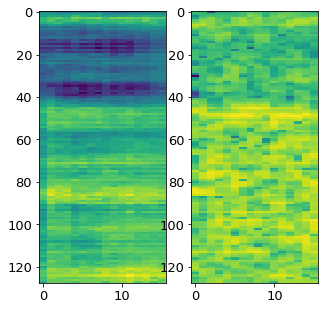

In [157]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    mu, logvar = E_module(images)

    out = D_module(mu)  
    print("output shape: ", out.size())
    break 
    
img = out[1][0].detach().cpu()
print(img)
print(img.shape) 

import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [151]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    mu, logvar = E_module(images)
    out = D_module(mu)    
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


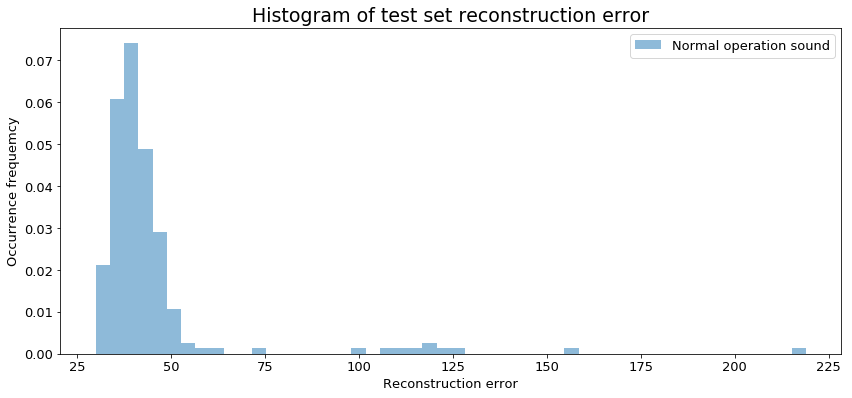

torch.Size([1, 128, 16])


In [158]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(1):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


## analysis 
the performance in this case got a lot worse. looking at the shape of the normal sound reconstruction error, we can see that the distribution became not very normal, with a large amount of outliers. The part around 30 seems to be more steep. This means for at least a certain group of inputs, the output became more confident that the sound is normal. However, for perhaps the part of the normal sound that sounded like the generated positive case, this broke down as the training procedure now confuses the model to reconstruct the these according to the similar positive examples seen during training. This could be due to a low snr on when constructing these training positves, meaning they were not suffuciently different from the normal sound. Increasing the 

torch.Size([1, 128, 16])
torch.Size([128, 16])


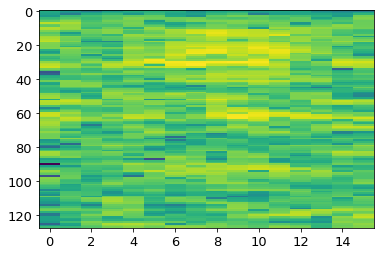

In [153]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.38403162199588464


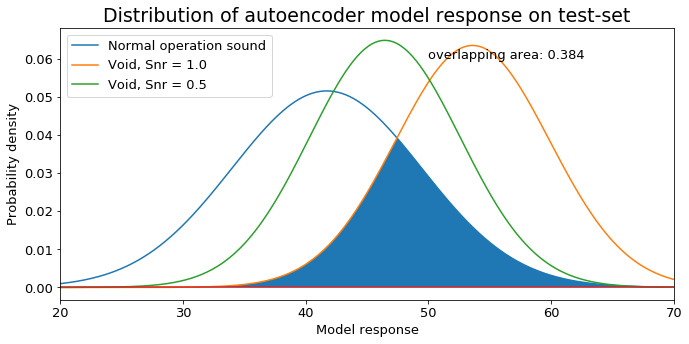

In [155]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


## 02/04/2021 

I was unable to get the network to train properly. this is a shame considering the paper in which it was proposed saw a good performance increase between this architecture and the basic autoencoder model. in order to train properly, more data is required as the model was getting a small sample of the various machine sounds data. 

If data can be found for various machine noises, then the network should be easier to train as it won't be as vulnerable to one side of the network getting too good at beating the other side of the network. 
